In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Core

> The `text.core` module contains the core bits required to use fast.ai's low-level and/or mid-level APIs to build `DataLoaders` and train NLP/Text sequence classification models 

In [ ]:
# |default_exp text.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from datasets import concatenate_datasets, load_dataset
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.transforms import (
    DataLoaders,
    Datasets,
    ColSplitter,
    ItemTransform,
    TfmdDL,
)
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.test_utils import show_install
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import (
    AutoConfig,
    AutoTokenizer,
    PretrainedConfig,
    PreTrainedTokenizerBase,
    PreTrainedModel,
)
from transformers import AutoModelForSequenceClassification
from transformers import logging as hf_logging
from transformers.data.data_collator import DataCollatorWithPadding

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb

from fastai.data.block import (
    CategoryBlock,
    ColReader,
    ColSplitter,
    DataBlock,
    ItemGetter,
    RandomSplitter,
    FuncSplitter,
)
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import (
    print_versions,
    PreCalculatedCrossEntropyLoss,
    PreCalculatedBCELoss,
    PreCalculatedMSELoss,
)

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = (
    imdb_dsd[0]
    .add_column("is_valid", [False] * len(imdb_dsd[0]))
    .shuffle()
    .select(range(1000))
)
valid_ds = (
    imdb_dsd[1]
    .add_column("is_valid", [True] * len(imdb_dsd[1]))
    .shuffle()
    .select(range(200))
)

# build a `DataFrame` representation as well
imdb_ds = concatenate_datasets([train_ds, valid_ds])
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(
    len(imdb_df[imdb_df["is_valid"] == False]),
    len(imdb_df[imdb_df["is_valid"] == True]),
)
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"Sure, for it's super imagery and awesome sound, it's a great home theater ""show off"" disk, but this is also a touching drama as well as an informative documentary. The parallel stories that are intertwined throughout this film will keep all viewers interested. Young, old, boys and girls alike will find that deep down, we are all fans of the automobile, especially the high performance indy machines that are the result of generations blood, sweat, tears, ingenuity and perseverance. The Mark Knopfler and Ry Cooder sound track is perfectly matched to the visuals and the content. I don't want t...",1,False
1,"This movie displayed more racial hatred of Jews by David Mamet than I have<br /><br />have ever encountered in an American film. The sterotypes are so over the top that my ability to continue watching died. I was so disappointed at Joe<br /><br />Mantegna calling a bunch of men ,sitting in a New York Jewish center cleaning weapons ,heros that common sense prevailed and I stopped. I am deeply<br /><br />disturbed at the concept that Jews are not Americans and ""different"". I suggest that Mr. Mamet is one of the causes of hatred not a healer of same.",0,False
2,"This film is the most cult movie on metal there is. Premise: A kid gets a hold of the final recording of his favorite artist Sammy Curr who recently dies in a hotel fire. He plays it backwards and summons him back from the dead to get revenge in the name of heavy metal on those b**tardly jocks who torment him. Any fan of true metal will enjoy this movie, and if you are a metal head being tormented by jocks, play a Sammy Curr album backwards.........no wait he is fictitious, well get a hold of this movie and watch it with your fist in the air, your head banging, and the volume at 11!",1,False
3,"Sugar &Spice is one of the worst movies of 2001. The film tries to cross Heathers and Bring It On and fails . When I saw last January I was so disgusted by the film that I walked and talked on my cell phone to my girlfriend for the last half hour of the movie. I've heard that the DVD has a director's cut maybe I'll check it out, but this PG-13 trash movie is s*** and the worst kind of s***. Maybe if the film had some T&A that would've have made it okay. But the gags are lame and the acting is horrible. Worse than a Troma film.",0,False
4,"Well I just gave away 95 minutes and 47 seconds that I'll never get back on this piece of trash. I heard someone online describe this movie's villains as ""subhuman cannibals"", and I thought it was promising because I thought it would be like the Descent. WRONG! The Descent was a psychological thriller with dynamic characters and strong storyline. These villains are totally unrealistic and no part of their performance is enjoyable to watch. This movie isn't so controversial, I've seen this level of gore in many films. This movie plain sucks. SYNOPSIS: A blonde who thinks she's real hot (but...",0,False


In [ ]:
labels = imdb_dsd[0].features["label"].names
labels

['neg', 'pos']

## Core: Data

A base collation function

### `TextCollatorWithPadding` -

In [ ]:
# |export
@dataclass
class TextCollatorWithPadding:
    def __init__(
        self,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str = None,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig = None,
        # A Hugging Face model
        hf_model: PreTrainedModel = None,
        # The number of inputs expected by your model
        n_inp: int = 1,
        # Defaults to use Hugging Face's DataCollatorWithPadding(tokenizer=hf_tokenizer)
        data_collator_cls: type = DataCollatorWithPadding,
        # kwyargs specific for the instantiation of the `data_collator`
        data_collator_kwargs: dict = {},
    ):
        store_attr()

        self.hf_tokenizer = data_collator_kwargs.pop("tokenizer", self.hf_tokenizer)
        self.data_collator = data_collator_cls(
            tokenizer=self.hf_tokenizer, **data_collator_kwargs
        )

    def __call__(self, features):
        features = L(features)
        inputs, labels, targs = [], [], []

        if isinstance(features[0], dict):
            feature_keys = list(features[0].keys())
            inputs = [
                {
                    fwd_arg_name: list(features.attrgot(fwd_arg_name))
                    for fwd_arg_name in self.hf_tokenizer.model_input_names
                    if fwd_arg_name in feature_keys
                }
            ]
            labels = [
                torch.tensor(
                    list(features.attrgot("label")) if "label" in feature_keys else []
                )
            ]
            targs = labels
        elif isinstance(features[0], tuple):
            for f_idx in range(self.n_inp):
                feature_keys = list(features[0][f_idx].keys())
                inputs.append(
                    {
                        fwd_arg_name: list(
                            features.itemgot(f_idx).attrgot(fwd_arg_name)
                        )
                        for fwd_arg_name in self.hf_tokenizer.model_input_names
                        if fwd_arg_name in feature_keys
                    }
                )
                labels.append(
                    torch.tensor(
                        list(features.itemgot(f_idx).attrgot("label"))
                        if "label" in feature_keys
                        else []
                    )
                )

            targs = [
                torch.tensor(list(features.itemgot(f_idx)))
                for f_idx in range(self.n_inp, len(features[0]))
            ]

        return self._build_batch(inputs, labels, targs)

    def _build_batch(self, inputs, labels, targs):
        batch = []

        for input, input_labels in zip(inputs, labels):
            if len(input_labels) > 0:
                input["labels"] = input_labels
            batch.append(dict(self.data_collator(input)))

        for targ in targs:
            batch.append(targ)

        return batch

## Core: Training

Base splitter, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules):
    "Return all parameters of `m`"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L133){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
def blurr_splitter_on_head(m: Module):
    """Creates two layer groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layer groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(
            inspect.signature(self.hf_model.forward).parameters.keys()
        )

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(
                self.learn.model, **self.base_model_wrapper_kwargs
            )

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Core: Examples

This section demonstrates how you can use PyTorch to build your `DataLoader` iterators and train your model using the fast.ai `Learner`. Note that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Step 1: HF objects

In [ ]:
model_cls = AutoModelForSequenceClassification
hf_logging.set_verbosity_error()

pretrained_model_name = "microsoft/deberta-v3-small"
n_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
)

test_eq(hf_arch, "deberta_v2")
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

print("=== config ===")
print(f"# of labels:\t{hf_config.num_labels}")
print("")
print("=== tokenizer ===")
print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
print(
    f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}"
)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['Sure, for it\'s super imagery and awesome sound, it\'s a great home theater "show off" disk, but this is also a touching drama as well as an informative documentary. The parallel stories that are intertwined throughout this film will keep all viewers interested. Young, old, boys and girls alike will find that deep down, we are all fans of the automobile, especially the high performance indy machines that are the result of generations blood, sweat, tears, ingenuity and perseverance. The Mark Knopfler and Ry Cooder sound track is perfectly matched to the visuals and the content. I don\'t want to give away the ending, but the final driving sequence to Quincy Jones\' "Days Like These" just might bring a tear to your eye. Enjoy it!', 'This movie displayed more racial hatred of Jews by David Mamet than I have<br /><br />have ever encountered in an American film. The sterotypes are so over the top that my ability to continue watching died. I was

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


#### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(
    proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator
)
valid_dl = torch.utils.data.DataLoader(
    proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator
)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0]))
print("")
print(b[1])

# b

250 25
2

[CLS] I just saw this movie tonight, opening night. It was great!! I'm a big fan of sports movies, and this was right up there as one of my favorites. Dennis Quaid was great. (Oh, by the way, Mr. Quaid, if you read this...my sister lives in Austin, where you live.....and she was supposed to buy you a drink once...well...she kinda stood you up...but she didn't mean to! :C) [not that anyone's going to believe that...]) ANYWAY, it's a great movie. Everyone who likes a good sports movie, should go out and see it! :C)[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

#### Step 5: Train

SuggestedLRs(minimum=8.317637839354575e-05, steep=6.309573450380412e-07, valley=0.0002290867705596611, slide=0.0010000000474974513)

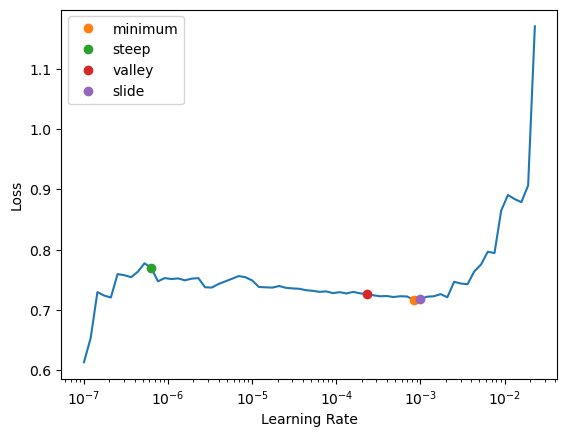

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.685007,0.686243,0.500000,00:22
1,0.317789,0.163332,0.925000,00:21
2,0.161609,0.149196,0.930000,00:22


In [ ]:
for m_name, m_val in zip(
    learn.recorder.metric_names[1:-1], learn.recorder.final_record
):
    print(m_name, m_val)

train_loss 0.16160863637924194
valid_loss 0.14919553697109222
accuracy 0.9300000071525574


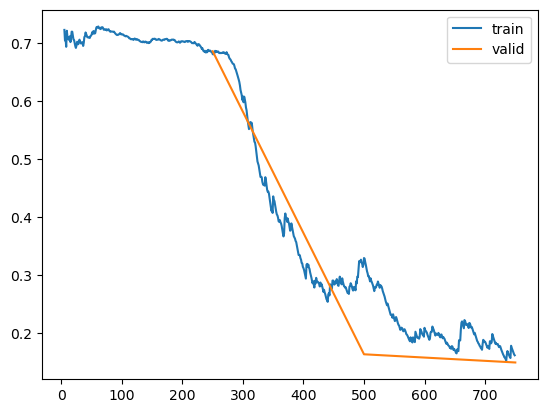

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API: Data

This section demonstrates how you can migrate from using PyTorch to fast.ai `Datasets` and `DataLoaders` to recapture much of the fast.ai specific features unavailable when using basic PyTorch.

### `TextInput` -

In [ ]:
# |export
class TextInput(TensorBase):
    """The base represenation of your inputs; used by the various fastai `show` methods"""

    pass

### `BatchDecodeTransform` -

In [ ]:
# |export
class BatchDecodeTransform(Transform):
    """A class used to cast your inputs as `input_return_type` for fastai `show` methods"""

    def __init__(
        self,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Any other keyword arguments
        **kwargs,
    ):
        store_attr()
        self.kwargs = kwargs

    def decodes(self, items):
        """Returns the proper object and data for show related fastai methods"""
        inps = self.input_return_type(items[0]["input_ids"])
        if len(items) > 1:
            return inps, *items[1:]
        else:
            labels = items[0].get("labels", [None] * items[0]["input_ids"])
            return inps, labels

### Utilities -

In [ ]:
# |export
def get_blurr_tfm(
    # A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...)
    tfms_list: Pipeline,
    # The transform to find
    tfm_class: Transform = BatchDecodeTransform,
):
    """
    Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
    instance used in your Blurr DataBlock
    """
    return next(filter(lambda el: issubclass(type(el), tfm_class), tfms_list), None)

In [ ]:
nbdev.show_doc(get_blurr_tfm, title_level=3)

---

### get_blurr_tfm

>      get_blurr_tfm (tfms_list:fastcore.transform.Pipeline,
>                     tfm_class:fastcore.transform.Transform=<class
>                     '__main__.BatchDecodeTransform'>)

Given a fastai DataLoaders batch transforms, this method can be used to get at a transform
instance used in your Blurr DataBlock

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| tfms_list | Pipeline |  | A list of transforms (e.g., dls.after_batch, dls.before_batch, etc...) |
| tfm_class | Transform | BatchDecodeTransform | The transform to find |

In [ ]:
# |export
def first_blurr_tfm(
    # Your fast.ai `DataLoaders
    dls: DataLoaders,
    # The Blurr transforms to look for in order
    tfms: list[Transform] = [BatchDecodeTransform],
):
    """
    This convenience method will find the first Blurr transform required for methods such as
    `show_batch` and `show_results`. The returned transform should have everything you need to properly
    decode and 'show' your Hugging Face inputs/targets
    """
    for tfm in tfms:
        found_tfm = get_blurr_tfm(dls.before_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

        found_tfm = get_blurr_tfm(dls.after_batch, tfm_class=tfm)
        if found_tfm:
            return found_tfm

In [ ]:
nbdev.show_doc(first_blurr_tfm, title_level=3)

---

### first_blurr_tfm

>      first_blurr_tfm (dls:fastai.data.core.DataLoaders,
>                       tfms:list[fastcore.transform.Transform]=[<class
>                       '__main__.BatchDecodeTransform'>])

This convenience method will find the first Blurr transform required for methods such as
`show_batch` and `show_results`. The returned transform should have everything you need to properly
decode and 'show' your Hugging Face inputs/targets

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dls | DataLoaders |  | Your fast.ai `DataLoaders |
| tfms | list[Transform] | [<class '__main__.BatchDecodeTransform'>] | The Blurr transforms to look for in order |

### `show_batch` -

In [ ]:
# |export
@typedispatch
def show_batch(
    # This typedispatched `show_batch` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # Your `DataLoaders`. This is required so as to get at the Hugging Face objects for
    # decoding them into something understandable
    dataloaders,
    # Your `show_batch` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_batch`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(dataloaders)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = dataloaders.n_inp

    n_samples = min(max_n, dataloaders.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        label = y[idx] if y is not None else None
        sample = samples[idx] if samples is not None else None

        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = (
                    [
                        trg_labels[idx]
                        for idx, val in enumerate(label.numpy().tolist())
                        if (val == 1)
                    ]
                    if (trg_labels)
                    else label.numpy()
                )
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        res.append(tuplify(rets))

    cols = ["text"] + [
        "target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp)
    ]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

### `TextDataLoader` -

In [ ]:
# |export
@delegates()
class TextDataLoader(TfmdDL):
    """
    A transformed `DataLoader` that works with Blurr.
    From the fastai docs: A `TfmDL` is described as "a DataLoader that creates Pipeline from a list of Transforms
    for the callbacks `after_item`, `before_batch` and `after_batch`. As a result, it can decode or show a processed batch.
    """

    def __init__(
        self,
        # A standard PyTorch Dataset
        dataset: torch.utils.data.dataset.Dataset | Datasets,
        # A Hugging Face tokenizer (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (not required if passing in an \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_arch: str = None,
        # A Hugging Face configuration object (not required if passing in an  \
        # instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_config: PretrainedConfig = None,
        # A Hugging Face model (not required if passing in an instance of `BatchTokenizeTransform` to `before_batch_tfm`)
        hf_model: PreTrainedModel = None,
        # An instance of `TextCollatorWithPadding` or equivalent (defaults to `BlurrBatchCreator`)
        text_collator: TextCollatorWithPadding = None,
        # The batch_tfm used to decode Blurr batches (defaults to `BatchDecodeTransform`)
        batch_decode_tfm: BatchDecodeTransform = None,
        # Used by typedispatched show methods
        input_return_type: type = TextInput,
        # Keyword arguments to be applied to your `batch_decode_tfm`
        batch_decode_kwargs: dict = {},
        # Keyword arguments to be applied to `BlurrDataLoader`
        **kwargs,
    ):
        # define what happens when a batch is created (e.g., this is where collation happens)
        if "create_batch" in kwargs:
            kwargs.pop("create_batch")
        if not text_collator:
            text_collator = TextCollatorWithPadding(
                hf_tokenizer, hf_arch, hf_config, hf_model
            )

        # define the transform applied after the batch is created (used of show methods)
        if "after_batch" in kwargs:
            kwargs.pop("after_batch")
        if not batch_decode_tfm:
            batch_decode_tfm = BatchDecodeTransform(
                hf_tokenizer,
                hf_arch,
                hf_config,
                hf_model,
                input_return_type,
                **batch_decode_kwargs.copy(),
            )

        super().__init__(
            dataset=dataset,
            create_batch=text_collator,
            after_batch=batch_decode_tfm,
            **kwargs,
        )
        store_attr(names="hf_arch, hf_config, hf_tokenizer, hf_model")

    def new(
        self,
        # A standard PyTorch and fastai dataset
        dataset: Union[torch.utils.data.dataset.Dataset, Datasets] = None,
        # The class you want to create an instance of (will be "self" if None)
        cls: type = None,
        #  Any additional keyword arguments you want to pass to the __init__ method of `cls`
        **kwargs,
    ):
        """
        We have to override the new method in order to add back the Hugging Face objects in this factory
        method (called for example in places like `show_results`). With the exception of the additions to the kwargs
        dictionary, the code below is pulled from the `DataLoaders.new` method as is.
        """
        # we need to add these arguments back in (these, after_batch, and create_batch will go in as kwargs)
        kwargs["hf_arch"] = self.hf_arch
        kwargs["hf_config"] = self.hf_config
        kwargs["hf_tokenizer"] = self.hf_tokenizer
        kwargs["hf_model"] = self.hf_model

        return super().new(dataset, cls, **kwargs)

## Low-Level API: Examples

### Using `Datasets` API

#### Step 1: HF objects

In [ ]:
model_cls = AutoModelForSequenceClassification
hf_logging.set_verbosity_error()

pretrained_model_name = "microsoft/deberta-v3-small"
n_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
)

test_eq(hf_arch, "deberta_v2")
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

print("=== config ===")
print(f"# of labels:\t{hf_config.num_labels}")
print("")
print("=== tokenizer ===")
print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
print(
    f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}"
)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {
        fwd_arg_name: example[fwd_arg_name]
        for fwd_arg_name in hf_tokenizer.model_input_names
        if fwd_arg_name in list(example.keys())
    }


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(
    items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1
)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 1


#### Step 3: `DataLoaders`

In [ ]:
def sorted_dl_func(item):
    return len(item[0]["input_ids"])


data_collator = TextCollatorWithPadding(hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sorted_dl_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0]))
print("")
print(b[1])

250 50
2

[CLS] I really love action/adventure films and this is one of the best. Of course, we love the stars of this genre, Bruce Willis, Sly Stallone, Clint Eastwood, Kurt Russell, Arnold Schwarzenegger and the rest, but its the story that really counts. The best are somewhat feasible but we can tolerate those that are a little "over the top" as in the comic book style of action. The more twists and turns, the more dire situations the heroes are involved in and the more shocking moments in the film; the more we action/adventure fans enjoy them. "In the Line of Fire" has ALL the elements required for a rip-roaring action thriller. It has Clint Eastwood as a near-retirement Secret Service Agent whose one bad moment of failure haunts him. It has one of the most evil, despicable, maniacal villains in John Malkovich, the type in which you can't wait to see him, "get his due". It has Rene Russo as the 'love interest.' It has twists and turns, an occasional shock and even a touch of warmth

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Will work assuming we define a suitable `show_batch()`` method for our examples
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1760)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1760 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1760 x 3072     
Linear                        

#### Step 5: Train

SuggestedLRs(minimum=9.120108734350651e-06, steep=0.0012022644514217973, valley=2.511886486900039e-05, slide=0.0014454397605732083)

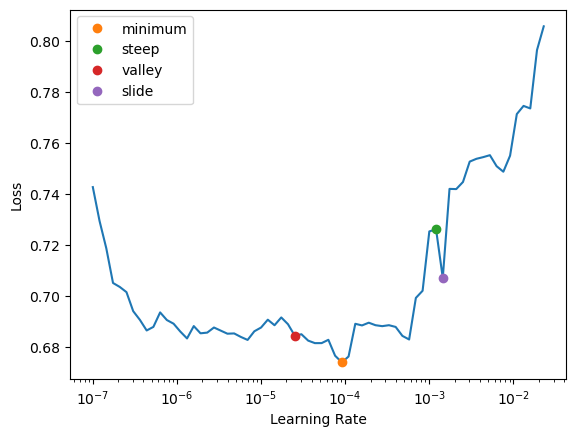

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.664256,0.583108,0.705000,00:26
1,0.234542,0.154581,0.940000,00:19
2,0.182595,0.146189,0.930000,00:19


In [ ]:
for m_name, m_val in zip(
    learn.recorder.metric_names[1:-1], learn.recorder.final_record
):
    print(m_name, m_val)

train_loss 0.18259531259536743
valid_loss 0.14618946611881256
accuracy 0.9300000071525574


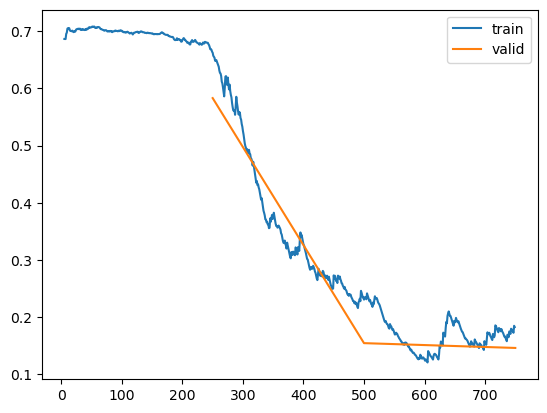

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Using `BatchDecodeTransform` and `TextDataLoader`

#### Step 1: HF objects

In [ ]:
model_cls = AutoModelForSequenceClassification
hf_logging.set_verbosity_error()

pretrained_model_name = "microsoft/deberta-v3-small"
n_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
)

test_eq(hf_arch, "deberta_v2")
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

print("=== config ===")
print(f"# of labels:\t{hf_config.num_labels}")
print("")
print("=== tokenizer ===")
print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
print(
    f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}"
)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
# proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# define dataset splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)
splits = splitter(proc_imdb_ds)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {
        fwd_arg_name: example[fwd_arg_name]
        for fwd_arg_name in hf_tokenizer.model_input_names
        if fwd_arg_name in list(example.keys())
    }


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(
    items=proc_imdb_ds, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1
)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ba70debb1bdaf2a8.arrow


#### Step 3: `DataLoaders`

In [ ]:
label_names = train_ds.features["label"].names
label_names

['neg', 'pos']

In [ ]:
batch_size = 4

trn_dl = TextDataLoader(
    dsets.train,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    shuffle=True,
    batch_size=batch_size,
)

val_dl = TextDataLoader(
    dsets.valid,
    hf_tokenizer,
    batch_decode_kwargs={"labels": label_names},
    batch_size=batch_size * 2,
)

dls = DataLoaders(trn_dl, val_dl)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0][:200]))
print("")
print(b[1])

250 25
2

[CLS] I really love action/adventure films and this is one of the best. Of course, we love the stars of this genre, Bruce Willis, Sly Stallone, Clint Eastwood, Kurt Russell, Arnold Schwarzenegger and the rest, but its the story that really counts. The best are somewhat feasible but we can tolerate those that are a little "over the top" as in the comic book style of action. The more twists and turns, the more dire situations the heroes are involved in and the more shocking moments in the film; the more we action/adventure fans enjoy them. "In the Line of Fire" has ALL the elements required for a rip-roaring action thriller. It has Clint Eastwood as a near-retirement Secret Service Agent whose one bad moment of failure haunts him. It has one of the most evil, despicable, maniacal villains in John Malkovich, the type in which you can't wait to see him, "get his due". It has Rene Russo as the 'love

tensor([1, 1, 1, 0, 0, 0, 1, 0])


In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

,text,target
0,"Well, I must say that this was one hell of a fun movie. Despite the fact that the dubbing was pretty cheesy, and there were some odd moments where the film seemed to turn dark blue for no apparent reason, I was not disappointed. The story was actually pretty interesting: the last member of the Poison Clan must track down the other five members and discover who among them is using their skills for evil, and who is using them for good. The catch being that during training, all of the clan were masked, and all have since returned to society in disguise and changed their names.<br /><br />The fights are a joy to watch, as each member of the Poison Clan has a different fighting style: toad (my favorite), snake, scorpion, lizard, and centipede. The fight scenes have the actors jumping all over t",pos
1,"STAR RATING: ***** The Works **** Just Misses the Mark *** That Little Bit In Between ** Lagging Behind * The Pits <br /><br />Mike Atherton (Dudikoff) is peacefully making his way in the Wild West when he spots a group of men mistreating a lady. Being a gentleman, he naturally steps in and puts a stop to this and in doing so kills the son of a nasty enforcer. This is just the beginning of a all guns blazing battle to the finish from which there will be only one winner.<br /><br />M Dudikoff is an action star who's never truly managed to take off with me. Maybe I discovered him too late and after the other film I saw with him in it last Monday, The Human Shield, it was just another Dud (ha ha) added to the list. But I have a thing for westerns, being films that just sort of transport me to",pos


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_batch()` back
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"I really love action/adventure films and this is one of the best. Of course, we love the stars of this genre, Bruce Willis, Sly Stallone, Clint Eastwood, Kurt Russell, Arnold Schwarzenegger and the rest, but its the story that really counts. The best",pos
1,"Hair is one of my favorite movies of all times. Even not being part of my generation, I already watched this movie 9 times and I can't get enough with the beautiful message of understanding,passion,beauty and love. This movie is against the Vietnam w",pos


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `learn.summary()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 605)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 605 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 605 x 3072      
Linear                         

#### Step 5: Train

SuggestedLRs(minimum=4.786300996784121e-05, steep=0.015848932787775993, valley=0.0002754228771664202, slide=0.0004786300996784121)

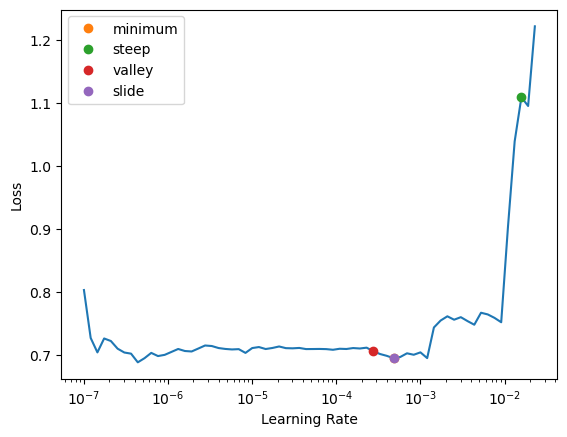

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.633243,0.371508,0.925000,00:23
1,0.227834,0.135452,0.950000,00:23
2,0.167090,0.127675,0.955000,00:24


In [ ]:
for m_name, m_val in zip(
    learn.recorder.metric_names[1:-1], learn.recorder.final_record
):
    print(m_name, m_val)

train_loss 0.16708984971046448
valid_loss 0.12767523527145386
accuracy 0.9549999833106995


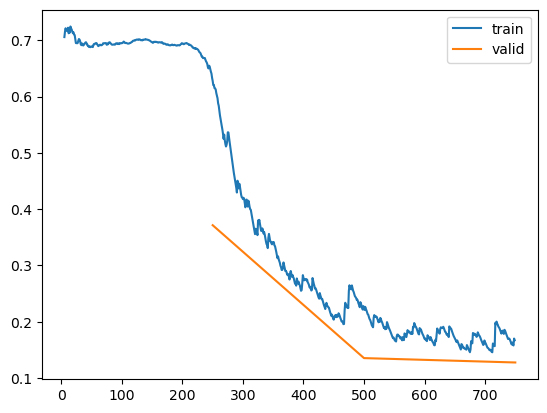

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-level API

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()